
Model Performance Metrics:

Random Forest:
RMSE: 127.78
R2 Score: 0.99
Cross-validation Score: 0.99 (+/- 0.00)

Gradient Boosting:
RMSE: 114.75
R2 Score: 0.99
Cross-validation Score: 0.99 (+/- 0.00)

Feature Importance:
              feature  importance
2  population_density    0.995619
1            humidity    0.001741
3   healthcare_access    0.001090
0         temperature    0.000660
4               month    0.000481
5         day_of_week    0.000411


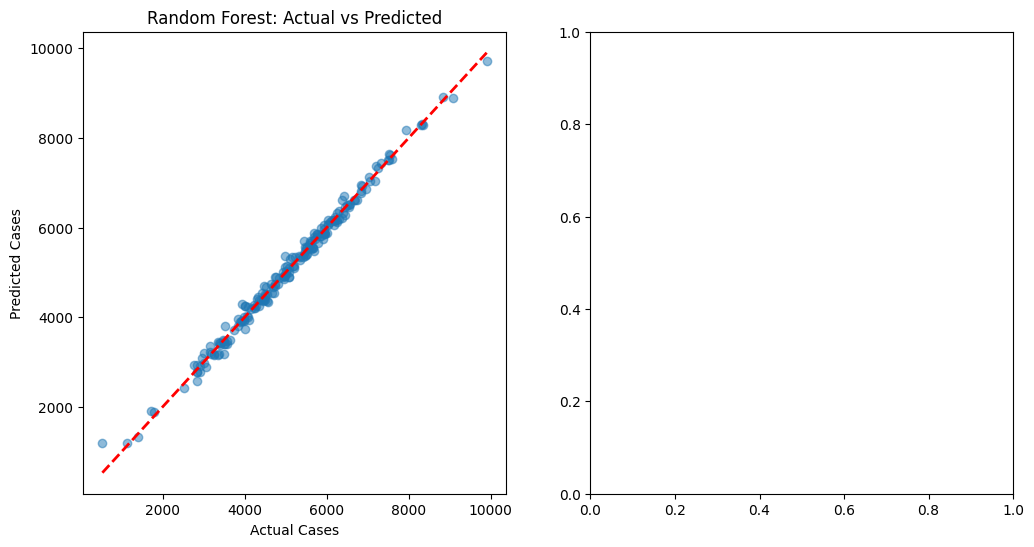

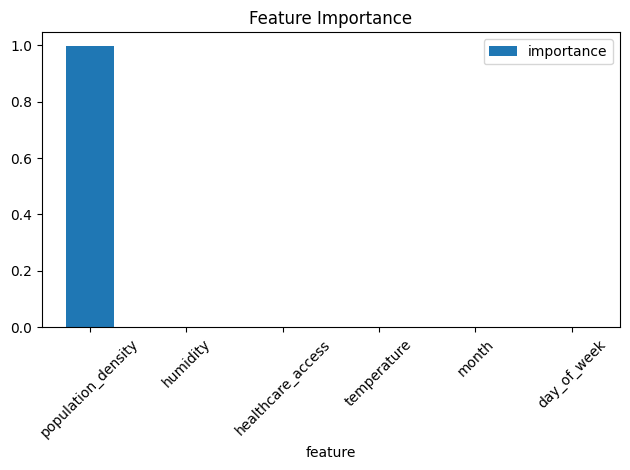


Predictions for next 7 days:
2022-09-27: 5097 cases
2022-09-28: 5087 cases
2022-09-29: 5088 cases
2022-09-30: 5084 cases
2022-10-01: 5098 cases
2022-10-02: 5098 cases
2022-10-03: 5123 cases


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Generate sample data (in real scenario, you would load your actual dataset)
np.random.seed(42)
n_samples = 1000

# Create date range
dates = pd.date_range(start='2020-01-01', periods=n_samples, freq='D')

# Generate features
temperature = np.random.normal(25, 5, n_samples)
humidity = np.random.normal(60, 15, n_samples)
population_density = np.random.normal(1000, 300, n_samples)
healthcare_access = np.random.normal(70, 20, n_samples)

# Generate target variables with some realistic relationships
cases = (0.3 * temperature + 0.4 * humidity + 0.5 * population_density -
         0.2 * healthcare_access + np.random.normal(0, 10, n_samples))
cases = np.abs(cases) * 10  # Make all values positive and scale up

deaths = cases * (0.4 + np.random.normal(0, 0.1, n_samples))  # ~40% fatality rate
deaths = np.abs(deaths)

# Create DataFrame
data = pd.DataFrame({
    'date': dates,
    'temperature': temperature,
    'humidity': humidity,
    'population_density': population_density,
    'healthcare_access': healthcare_access,
    'confirmed_cases': cases.astype(int),
    'deaths': deaths.astype(int)
})

# Add some missing values to simulate real-world scenarios
for col in ['temperature', 'humidity', 'healthcare_access']:
    mask = np.random.random(len(data)) < 0.1
    data.loc[mask, col] = np.nan

# Calculate CFR
data['cfr'] = (data['deaths'] / data['confirmed_cases']) * 100

# Feature engineering
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek

# Handle missing values using KNN imputation
imputer = KNNImputer(n_neighbors=5)
features_for_imputation = ['temperature', 'humidity', 'population_density', 'healthcare_access']
data[features_for_imputation] = imputer.fit_transform(data[features_for_imputation])

# Prepare features and targets
X = data[['temperature', 'humidity', 'population_density', 'healthcare_access',
          'month', 'day_of_week']]
y_cases = data['confirmed_cases']
y_deaths = data['deaths']
y_cfr = data['cfr']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_cases_train, y_cases_test = train_test_split(
    X_scaled, y_cases, test_size=0.2, random_state=42
)

# Initialize models
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Train and evaluate models
models = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

results = {}

for name, model in models.items():
    # Train model
    model.fit(X_train, y_cases_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_cases_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_cases_test, y_pred)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_scaled, y_cases, cv=5, scoring='r2')

    results[name] = {
        'RMSE': rmse,
        'R2': r2,
        'CV_mean': cv_scores.mean(),
        'CV_std': cv_scores.std()
    }

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Print results
print("\nModel Performance Metrics:")
print("=" * 50)
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"RMSE: {metrics['RMSE']:.2f}")
    print(f"R2 Score: {metrics['R2']:.2f}")
    print(f"Cross-validation Score: {metrics['CV_mean']:.2f} (+/- {metrics['CV_std']*2:.2f})")

print("\nFeature Importance:")
print("=" * 50)
print(feature_importance)

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_cases_test, rf_model.predict(X_test), alpha=0.5)
plt.plot([y_cases_test.min(), y_cases_test.max()], [y_cases_test.min(), y_cases_test.max()], 'r--', lw=2)
plt.xlabel('Actual Cases')
plt.ylabel('Predicted Cases')
plt.title('Random Forest: Actual vs Predicted')

plt.subplot(1, 2, 2)
feature_importance.plot(x='feature', y='importance', kind='bar')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Function for making new predictions
def predict_cases(new_data):
    """
    Make predictions for new data.
    new_data should be a DataFrame with the same features used in training
    """
    new_data_scaled = scaler.transform(new_data)
    predictions = rf_model.predict(new_data_scaled)
    return predictions

# Example of making predictions for next 7 days
last_date = data['date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7, freq='D')

future_data = pd.DataFrame({
    'temperature': [25] * 7,
    'humidity': [60] * 7,
    'population_density': [1000] * 7,
    'healthcare_access': [70] * 7,
    'month': future_dates.month,
    'day_of_week': future_dates.dayofweek
})

future_predictions = predict_cases(future_data)

print("\nPredictions for next 7 days:")
print("=" * 50)
for date, pred in zip(future_dates, future_predictions):
    print(f"{date.date()}: {int(pred)} cases")